In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# Set seeds
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [20]:
from medmnist import INFO, BloodMNIST
from torchvision.transforms import Compose, ToTensor, Resize, RandomHorizontalFlip, RandomVerticalFlip, RandomAffine, RandomResizedCrop
root = './data'
def load_bloodmnist_dataloaders(batch_size=16, num_clients=6, subset_ratio=1.0, iid=True):
    # Transform
    train_transform = Compose([
        RandomHorizontalFlip(), RandomVerticalFlip(), RandomAffine(degrees=10, translate=(0.1, 0.1)),
        RandomResizedCrop(size=224, scale=(0.75, 1.0), ratio=(0.9, 1.1)),
        ToTensor()
    ])
    test_transform = Compose([Resize(224), ToTensor()])

    # Dataset
    train_dataset = BloodMNIST(split='train', transform=train_transform, download=True,root=root)
    test_dataset = BloodMNIST(split='test', transform=test_transform, download=True,root=root)

    # Subset training
    if subset_ratio < 1.0:
        n_subset = int(len(train_dataset) * subset_ratio)
        train_dataset = torch.utils.data.Subset(train_dataset, list(range(n_subset)))

    # Global test loader
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2*batch_size, shuffle=False)

    # Distribute training data
    client_loaders = []
    if iid:
        lengths = [len(train_dataset) // num_clients] * num_clients
        for i in range(len(train_dataset) % num_clients):
            lengths[i] += 1
        subsets = torch.utils.data.random_split(train_dataset, lengths)
        for subset in subsets:
            loader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=True)
            client_loaders.append(loader)
    else:
        # Non-IID by label grouping
        labels = np.array([train_dataset[i][1] for i in range(len(train_dataset))])
        class_indices = {i: np.where(labels == i)[0].tolist() for i in range(8)}
        client_indices = [[] for _ in range(num_clients)]
        for cls in range(8):
            cls_samples = class_indices[cls]
            random.shuffle(cls_samples)
            chunks = np.array_split(cls_samples, num_clients)
            for i in range(num_clients):
                client_indices[i].extend(chunks[i])
        for indices in client_indices:
            subset = torch.utils.data.Subset(train_dataset, indices)
            loader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=True)
            client_loaders.append(loader)

    return client_loaders, test_loader


In [21]:

client_loaders_iid, test_loader = load_bloodmnist_dataloaders(batch_size=8, subset_ratio=0.2, iid=True)
client_loaders_non_iid, _ = load_bloodmnist_dataloaders(batch_size=8, subset_ratio=0.2, iid=False)


Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz


In [22]:
# Residual Block used after intermediate ViT block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels=768, drop_rate=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=drop_rate)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.pool = nn.AvgPool2d(kernel_size=14)  # Reduce to (1,1)

    def forward(self, x):
        # Convert from (B, L, C) to (B, C, H, W) if needed
        if x.ndim == 3:
            B, L, C = x.shape
            patch_tokens = x[:, 1:, :]  # remove CLS token → (B, 196, D)
            x = patch_tokens.permute(0, 2, 1).contiguous().view(B, C, 14, 14)
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)
        out = self.pool(out)
        return out.view(out.size(0), -1)  # Flatten to (B, 768)


# MLP classifier as client-specific tail
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=768, num_classes=8):
        super().__init__()
        self.fc = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Linear(input_dim, num_classes)
        )

    def forward(self, x):
        return self.fc(x)


# Vision Transformer with block sampling support
import timm
class FeSViBSModel(nn.Module):
    def __init__(self, vit_name='vit_base_r50_s16_224', num_clients=6, num_classes=8, pretrained=False, drop_rate=0.5):
        super().__init__()
        self.vit = timm.create_model(vit_name, pretrained=pretrained, num_classes=num_classes, in_chans=3)
        self.num_clients = num_clients
        self.patch_embed = nn.ModuleList([nn.Sequential(self.vit.patch_embed) for _ in range(num_clients)])
        self.res_block = ResidualBlock(drop_rate=drop_rate)
        self.client_tails = nn.ModuleList([MLPClassifier(num_classes=num_classes) for _ in range(num_clients)])

    def forward(self, x, client_idx, block_num):
        x = self.patch_embed[client_idx](x)  # Shape: (B, C, H, W) → (B, L, D)
        if x.dim == 4:
            B, D, H, W = x.shape
            x = x.flatten(2).transpose(1, 2)  # (B, D, H*W) → (B, L, D)
        else:
            B = x.shape[0]
        x = torch.cat([self.vit.cls_token.expand(B, -1, -1), x], dim=1)
        x = self.vit.pos_drop(x + self.vit.pos_embed)

        for i in range(block_num):
            x = self.vit.blocks[i](x)
        x = self.vit.norm(x)
        x = self.res_block(x)
        return self.client_tails[client_idx](x)


In [25]:
def extract_vit_weights(model, device):
    """Returns a dict of flattened weights: blocks, cls_token, pos_embed"""
    return {
        'blocks': torch.cat([p.data.flatten() for p in model.vit.blocks.parameters()]).detach().cpu(),
        'cls': model.vit.cls_token.detach().cpu(),
        'pos_embed': model.vit.pos_embed.detach().cpu()
    }

def apply_vit_weights(model, agg_weights, device):
    """Apply aggregated weights back to the model"""
    idx = 0
    for p in model.vit.blocks.parameters():
        numel = p.numel()
        new_val = agg_weights['blocks'][idx:idx+numel].view(p.shape).to(device)
        p.data.copy_(new_val)
        idx += numel
    model.vit.cls_token.data = agg_weights['cls'].to(device).clone()
    model.vit.pos_embed.data = agg_weights['pos_embed'].to(device).clone()

def train_fesvibs(model, client_loaders, test_loader, num_rounds=2, local_epochs=1, lr=1e-4, save_every=1):
    num_clients = len(client_loaders)
    criterion = nn.CrossEntropyLoss()
    optimizers = [optim.Adam(model.client_tails[i].parameters(), lr=lr) for i in range(num_clients)]

    history = {
        'train_loss': [[] for _ in range(num_clients)],
        'train_acc': [[] for _ in range(num_clients)],
        'test_acc': []
    }

    for rnd in range(num_rounds):
        print(f"\n================= ROUND {rnd+1}/{num_rounds} =================")
        client_weights = []
        for client_idx in range(num_clients):
            print(f"\nTraining Client {client_idx}...")

            # Randomly choose a block number for this round
            chosen_block = random.randint(1, 6)
            print(f"  Chosen Block: {chosen_block}")
            model.train()

            total_loss = 0.0
            total_correct = 0
            total_samples = 0

            for epoch in range(local_epochs):
                for batch in tqdm(client_loaders[client_idx]):
                    x = batch[0].to(device)
                    y = batch[1].view(-1).long().to(device)
                    optimizers[client_idx].zero_grad()
                    logits = model(x, client_idx, chosen_block)
                    # for batch_idx, (x, y) in enumerate(client_loaders[client_idx]):
                    #     print(f"Batch {batch_idx}: x shape = {x.shape}, y shape = {y.shape}")
                    #     if y.shape[0] == 0:
                    #         print(f"Warning: Empty target batch at index {batch_idx}. Skipping batch.")
                    #         continue  # Skip empty batch
                    loss = criterion(logits, y)
                    loss.backward()
                    optimizers[client_idx].step()

                    total_loss += loss.item() * y.size(0)
                    total_correct += (logits.argmax(dim=1) == y).sum().item()
                    total_samples += y.size(0)

            avg_loss = total_loss / total_samples
            avg_acc = total_correct / total_samples
            history['train_loss'][client_idx].append(avg_loss)
            history['train_acc'][client_idx].append(avg_acc)
            print(f"  Loss: {avg_loss:.4f} | Accuracy: {avg_acc:.4f}")

            # Save weights for FedAvg
            weights = extract_vit_weights(model, device)
            client_weights.append(weights)

        # ================= Aggregation (FedAvg) ====================
        print("\nAggregating weights...")
        agg = {}
        agg['blocks'] = sum(w['blocks'] for w in client_weights) / num_clients
        agg['cls'] = sum(w['cls'] for w in client_weights) / num_clients
        agg['pos_embed'] = sum(w['pos_embed'] for w in client_weights) / num_clients
        apply_vit_weights(model, agg, device)

        # ================= Evaluation ====================
        model.eval()
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0].to(device)
                y = batch[1].view(-1).long().to(device)
                logits = model(x, client_idx=0, block_num=4)  # Use mid-block for eval
                total_correct += (logits.argmax(dim=1) == y).sum().item()
                total_samples += y.size(0)
        test_acc = total_correct / total_samples
        history['test_acc'].append(test_acc)
        print(f"\n[Round {rnd+1}] Global Test Accuracy: {test_acc:.4f}")

    return history


In [26]:
# ======== Configurations ========
subset_ratio = 0.05
batch_size = 2
num_clients = 6
num_rounds = 3
local_epochs = 1
iid = True  # Change to True for IID experiment

# ======== Load Data ========
client_loaders, test_loader = load_bloodmnist_dataloaders(
    batch_size=batch_size,
    num_clients=num_clients,
    subset_ratio=subset_ratio,
    iid=iid
)

# ======== Initialize Model ========
model = FeSViBSModel(num_clients=num_clients, num_classes=8, pretrained=False).to(device)

# ======== Train & Evaluate ========
history = train_fesvibs(
    model,
    client_loaders,
    test_loader,
    num_rounds=num_rounds,
    local_epochs=local_epochs,
    lr=1e-4
)


Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz

================= ROUND 1/3 =================

Training Client 0...
  Chosen Block: 5


100%|██████████| 50/50 [00:03<00:00, 16.12it/s]


  Loss: 2.0500 | Accuracy: 0.2100

Training Client 1...
  Chosen Block: 6


100%|██████████| 50/50 [00:03<00:00, 15.00it/s]


  Loss: 2.0308 | Accuracy: 0.2200

Training Client 2...
  Chosen Block: 1


100%|██████████| 50/50 [00:02<00:00, 17.71it/s]


  Loss: 2.0075 | Accuracy: 0.2600

Training Client 3...
  Chosen Block: 2


100%|██████████| 50/50 [00:02<00:00, 17.59it/s]


  Loss: 2.0875 | Accuracy: 0.2222

Training Client 4...
  Chosen Block: 1


100%|██████████| 50/50 [00:02<00:00, 24.74it/s]


  Loss: 2.1046 | Accuracy: 0.1515

Training Client 5...
  Chosen Block: 4


100%|██████████| 50/50 [00:03<00:00, 16.41it/s]


  Loss: 2.1671 | Accuracy: 0.1313

Aggregating weights...

[Round 1] Global Test Accuracy: 0.1897

================= ROUND 2/3 =================

Training Client 0...
  Chosen Block: 3


100%|██████████| 50/50 [00:02<00:00, 21.16it/s]


  Loss: 1.9413 | Accuracy: 0.2800

Training Client 1...
  Chosen Block: 4


100%|██████████| 50/50 [00:02<00:00, 16.83it/s]


  Loss: 1.9020 | Accuracy: 0.2400

Training Client 2...
  Chosen Block: 2


100%|██████████| 50/50 [00:01<00:00, 25.46it/s]


  Loss: 1.9130 | Accuracy: 0.2800

Training Client 3...
  Chosen Block: 4


100%|██████████| 50/50 [00:02<00:00, 17.34it/s]


  Loss: 1.9521 | Accuracy: 0.1717

Training Client 4...
  Chosen Block: 6


100%|██████████| 50/50 [00:02<00:00, 18.38it/s]


  Loss: 2.0229 | Accuracy: 0.2222

Training Client 5...
  Chosen Block: 2


100%|██████████| 50/50 [00:02<00:00, 19.54it/s]


  Loss: 2.0206 | Accuracy: 0.1313

Aggregating weights...

[Round 2] Global Test Accuracy: 0.2596

================= ROUND 3/3 =================

Training Client 0...
  Chosen Block: 4


100%|██████████| 50/50 [00:02<00:00, 23.58it/s]


  Loss: 1.8594 | Accuracy: 0.3300

Training Client 1...
  Chosen Block: 5


100%|██████████| 50/50 [00:02<00:00, 17.67it/s]


  Loss: 1.8486 | Accuracy: 0.2800

Training Client 2...
  Chosen Block: 5


100%|██████████| 50/50 [00:02<00:00, 21.16it/s]


  Loss: 1.9908 | Accuracy: 0.2400

Training Client 3...
  Chosen Block: 4


100%|██████████| 50/50 [00:02<00:00, 17.26it/s]


  Loss: 1.7705 | Accuracy: 0.3737

Training Client 4...
  Chosen Block: 6


100%|██████████| 50/50 [00:03<00:00, 15.60it/s]


  Loss: 1.8859 | Accuracy: 0.2727

Training Client 5...
  Chosen Block: 6


100%|██████████| 50/50 [00:02<00:00, 17.12it/s]


  Loss: 1.8591 | Accuracy: 0.3232

Aggregating weights...

[Round 3] Global Test Accuracy: 0.3335


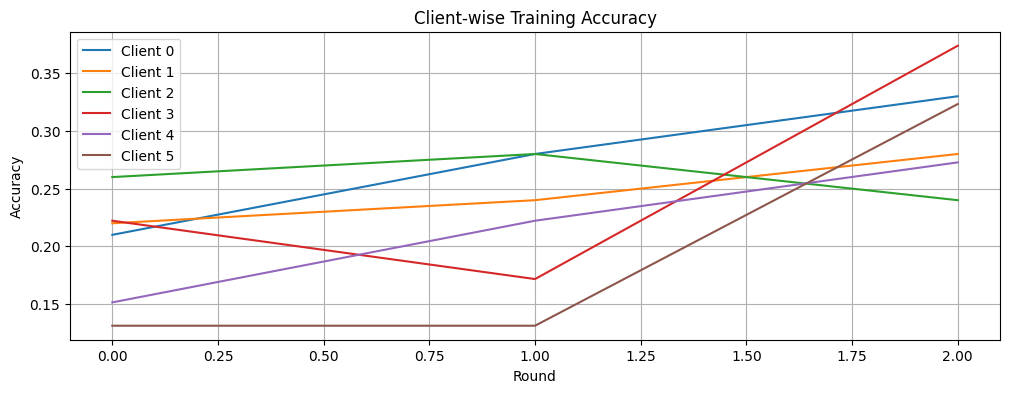

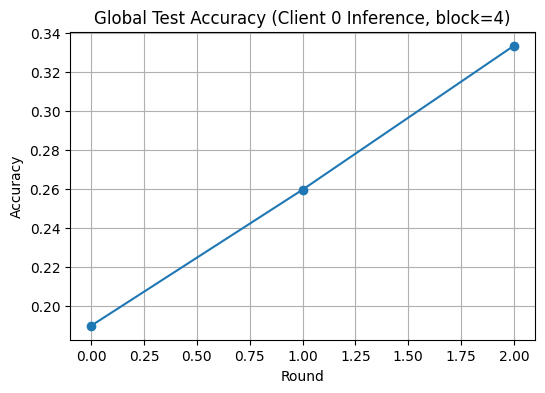

In [27]:
# Plot per-client training accuracy
plt.figure(figsize=(12, 4))
for i in range(num_clients):
    plt.plot(history['train_acc'][i], label=f'Client {i}')
plt.title("Client-wise Training Accuracy")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot global test accuracy
plt.figure(figsize=(6, 4))
plt.plot(history['test_acc'], marker='o')
plt.title("Global Test Accuracy (Client 0 Inference, block=4)")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


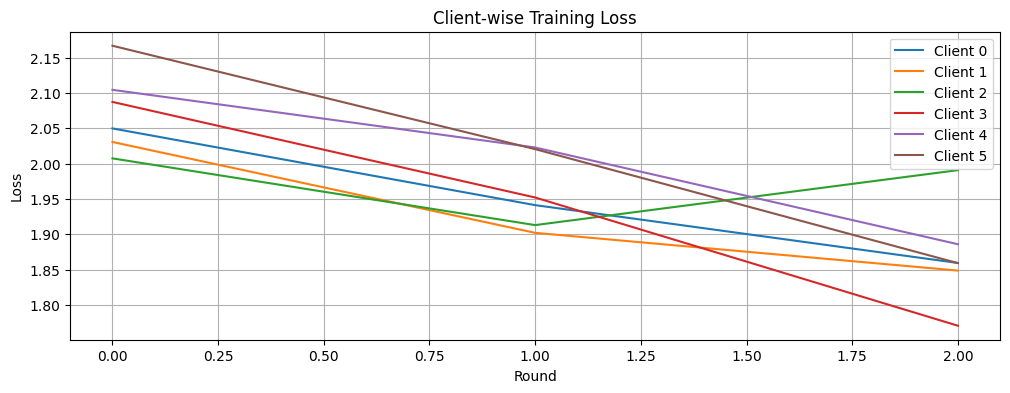

In [28]:
plt.figure(figsize=(12, 4))
for i in range(num_clients):
    plt.plot(history['train_loss'][i], label=f'Client {i}')
plt.title("Client-wise Training Loss")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
def plot_class_distribution(client_loaders, num_classes=8, title="Class Distribution Across Clients"):
    class_counts = np.zeros((len(client_loaders), num_classes), dtype=int)

    for client_idx, loader in enumerate(client_loaders):
        for _, labels in loader:
            labels = labels.numpy().flatten()
            for label in labels:
                class_counts[client_idx][label] += 1

    plt.figure(figsize=(12, 5))
    bottom = np.zeros(len(client_loaders))
    colors = plt.cm.tab10.colors

    for cls in range(num_classes):
        plt.bar(range(len(client_loaders)), class_counts[:, cls], bottom=bottom, label=f"Class {cls}", color=colors[cls % len(colors)])
        bottom += class_counts[:, cls]

    plt.xlabel("Client Index")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid(axis='y')
    plt.show()


Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz


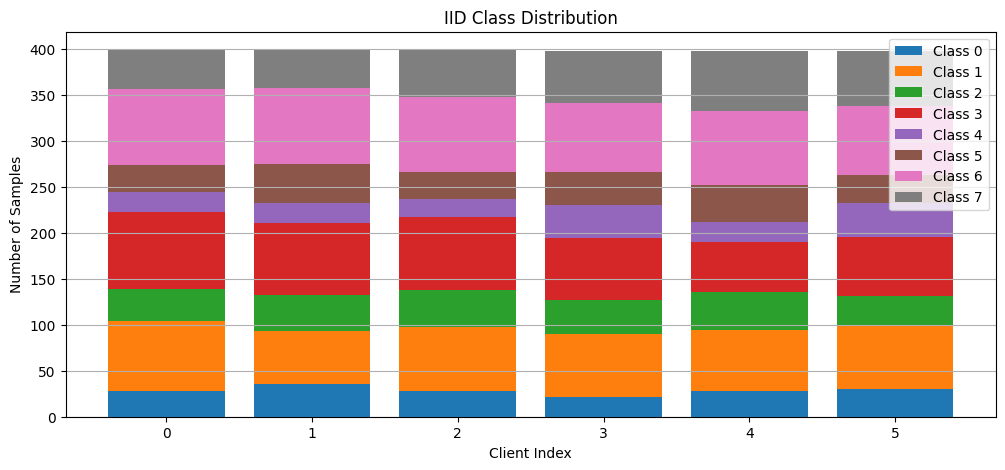

In [31]:
if not iid:
    # For Non-IID
    client_loaders_non_iid, _ = load_bloodmnist_dataloaders(subset_ratio=0.2, iid=False)
    plot_class_distribution(client_loaders_non_iid, title="Non-IID Class Distribution")
else:
    # For IID
    client_loaders_iid, _ = load_bloodmnist_dataloaders(subset_ratio=0.2, iid=True)
    plot_class_distribution(client_loaders_iid, title="IID Class Distribution")
